# Monet Style GAN Creation

## Problem Description

The task is to build a Generative Adversarial Network (GAN) that generates 7,000 to 10,000 images in the style of Claude Monet. A GAN consists of two neural networks: a generator and a discriminator. The generator creates images while the discriminator evaluates them, distinguishing between real and generated images. The competition requires creating Monet-style images from a given dataset.

[Github Repo](https://github.com/BaffinLee/Monet-Style-GAN-Creation)

## Data Description

The dataset is from [kaggle](https://www.kaggle.com/competitions/gan-getting-started), contains four directories:

- monet_jpg: 300 Monet paintings sized 256x256 in JPEG format.
- monet_tfrec: 300 Monet paintings sized 256x256 in TFRecord format.
- photo_jpg: 7028 photos sized 256x256 in JPEG format.
- photo_tfrec: 7028 photos sized 256x256 in TFRecord format.

Both TFRecord and JPEG formats are provided for ease of use depending on the training framework.

## Setup

In [1]:
import tensorflow as tf
import os

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

IS_DEV = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'

2024-06-27 17:50:39.211447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 17:50:39.211554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 17:50:39.334687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.15.0


## Exploratory Data Analysis (EDA)

### Load Data And Inspect

I will use TFRecordDataset from tensorflow library to load tfrec images, and decode image data to the shape of (256, 256, 256, 3), which means 256 pixel * 256 pixel * 3 (RGB).

In [2]:
base_path = '/kaggle/input/gan-getting-started'

def parse_image(proto):
    keys_to_features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = parsed_features['image']
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def load_dataset(path):
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

photo_dataset = load_dataset(f'{base_path}/photo_tfrec/*.tfrec')
monet_dataset = load_dataset(f'{base_path}/monet_tfrec/*.tfrec')

print(photo_dataset)
print(monet_dataset)

num_photo = sum(1 for _ in photo_dataset)
print(f"Number of records in the photo dataset: {num_photo}")

num_monet = sum(1 for _ in monet_dataset)
print(f"Number of records in the monent dataset: {num_monet}")

<_PrefetchDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
<_PrefetchDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
Number of records in the photo dataset: 7038
Number of records in the monent dataset: 300


### Visualizations

Let's start by visualizing a few samples from each category to understand the data better.

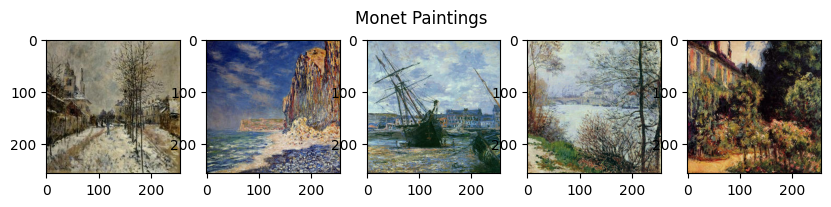

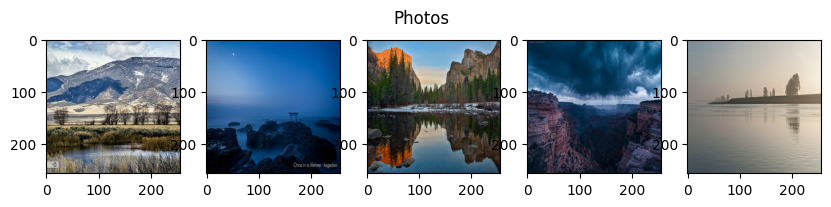

In [3]:
import matplotlib.pyplot as plt

def display_images(dataset, title, num_images=5):
    plt.figure(figsize=(10, 2))
    for i, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image * 0.5 + 0.5)
    plt.suptitle(title)
    plt.show()

display_images(monet_dataset, "Monet Paintings")
display_images(photo_dataset, "Photos")

Let's find out how the pixel color (RGB) distribute.

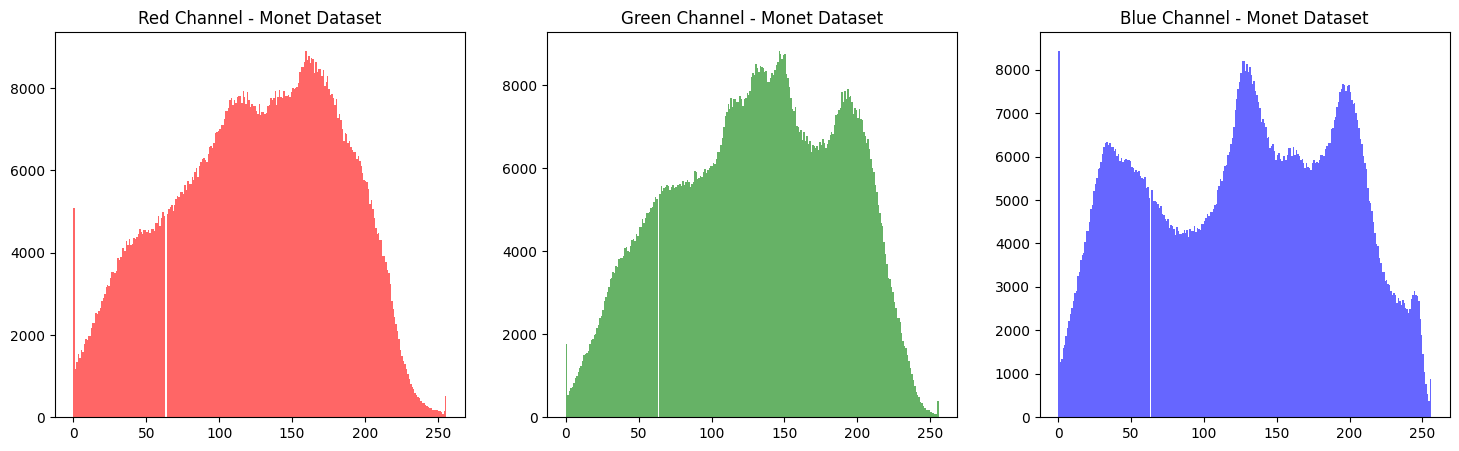

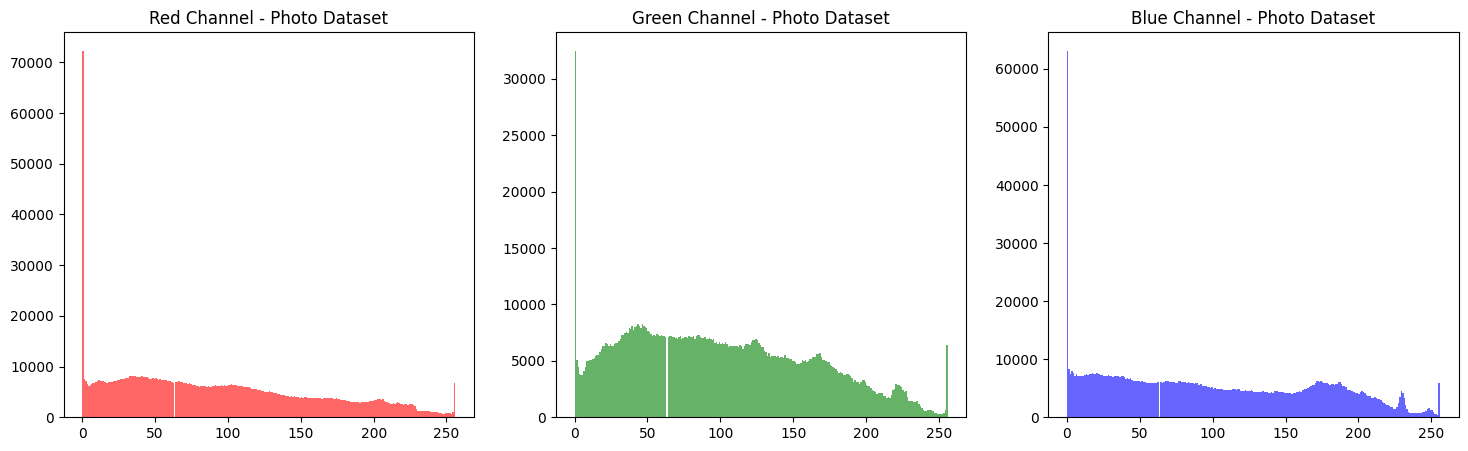

In [4]:
import numpy as np

def calculate_rgb_distribution(images):
    red_values = []
    green_values = []
    blue_values = []

    for img in images:
        red_values.extend(np.array((img[:, :, 0]  + 1) * 127.5).flatten())
        green_values.extend(np.array((img[:, :, 1]  + 1) * 127.5).flatten())
        blue_values.extend(np.array((img[:, :, 2]  + 1) * 127.5).flatten())

    return red_values, green_values, blue_values

def plot_rgb_distribution(red, green, blue, title):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.hist(red, bins=256, color='red', alpha=0.6, range=(0, 256))
    plt.title(f'Red Channel - {title}')

    plt.subplot(1, 3, 2)
    plt.hist(green, bins=256, color='green', alpha=0.6, range=(0, 256))
    plt.title(f'Green Channel - {title}')

    plt.subplot(1, 3, 3)
    plt.hist(blue, bins=256, color='blue', alpha=0.6, range=(0, 256))
    plt.title(f'Blue Channel - {title}')

    plt.show()
    
# Calculate RGB distributions for both datasets
red_A, green_A, blue_A = calculate_rgb_distribution(monet_dataset.take(20))
red_B, green_B, blue_B = calculate_rgb_distribution(photo_dataset.take(20))

# Plot RGB distributions
plot_rgb_distribution(red_A, green_A, blue_A, 'Monet Dataset')
plot_rgb_distribution(red_B, green_B, blue_B, 'Photo Dataset')

From above plots of distribution of RGBs, we can know that photo dataset have a more balanced distribution of RGB values.

### Data Cleaning

No significant data cleaning is necessary as the data is already preprocessed and sized to 256x256 pixels. However, we need to ensure that the images are correctly loaded and preprocessed before training the GAN.

### Plan of Analysis

- Data Preparation: Convert TFRecords to usable image tensors.
- Model Development: Build and train the GAN.
- Hyperparameter Tuning: Experiment with different architectures and parameters.
- Image Generation: Generate the required number of Monet-style images.

## Model Architecture

I am going to implement a CycleGAN for style transfer between two distinct sets of images.

**Generator**

The generator network uses a U-Net architecture with down-sampling and up-sampling layers. It includes:

- Convolutional layers with LeakyReLU activations for down-sampling.
- Transposed convolutions with ReLU activations for up-sampling.
- Skip connections to retain high-resolution features.

In [5]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, Activation, Concatenate
from tensorflow.keras.models import Model

def build_generator():
    def conv2d(layer_input, filters, f_size=4):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(negative_slope=0.2)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4):
        """Layers used during upsampling"""
        u = Conv2DTranspose(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        u = Activation('relu')(u)
        u = Concatenate()([u, skip_input])
        return u

    img = Input(shape=(256, 256, 3))

    # Downsampling
    d1 = conv2d(img, 64)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)

    # Upsampling
    u1 = deconv2d(d4, d3, 256)
    u2 = deconv2d(u1, d2, 128)
    u3 = deconv2d(u2, d1, 64)

    output_img = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(u3)

    return Model(img, output_img)

build_generator().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,408 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ activation[0][0], │
│ (Concatenate)       │ 512)              │            │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │  1,048,704 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (Concatenate)       │ 256)              │            │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │    262,208 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_transpose

 Total params: 6,171,011 (23.54 MB)

 Trainable params: 6,171,011 (23.54 MB)

 Non-trainable params: 0 (0.00 B)


**Discriminator**

The discriminator is a PatchGAN, classifying each N x N patch of the image. It includes:

- Convolutional layers with LeakyReLU activations.
- A final output layer that classifies the patches as real or fake.

In [6]:
from tensorflow.keras.layers import BatchNormalization

def build_discriminator():
    def d_layer(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        if normalization:
            d = BatchNormalization()(d)
        d = LeakyReLU(negative_slope=0.2)(d)
        return d

    img = Input(shape=(256, 256, 3))

    d1 = d_layer(img, 64, normalization=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

build_discriminator().summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Training Loop

Define the loss functions and the training step.

In [7]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import gc

def train_cycle_gan(batch_size, epochs, learning_rate):
    # Initialize generators and discriminators
    G = build_generator()  # X to Y
    F = build_generator()  # Y to X
    D_X = build_discriminator()  # Real or fake X
    D_Y = build_discriminator()  # Real or fake Y

    # Compile the discriminators
    D_X.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    D_Y.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    # Define the combined model
    real_X = Input(shape=(256, 256, 3))
    real_Y = Input(shape=(256, 256, 3))

    # Generate fake Y and fake X
    fake_Y = G(real_X)
    fake_X = F(real_Y)

    # Reconstructed images
    recon_X = F(fake_Y)
    recon_Y = G(fake_X)

    # Identity mapping
    img_X = G(real_X)
    img_Y = F(real_Y)

    # For the combined model only update the generators
    D_X.trainable = False
    D_Y.trainable = False

    # Discriminators' outputs
    valid_X = D_X(fake_X)
    valid_Y = D_Y(fake_Y)

    combined = Model(inputs=[real_X, real_Y], outputs=[valid_X, valid_Y, recon_X, recon_Y, img_X, img_Y])
    combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                     loss_weights=[1, 1, 10, 10, 1, 1],
                     optimizer=Adam(learning_rate, 0.5))

    dataset = tf.data.Dataset.zip((
        photo_dataset,
        monet_dataset.take(batch_size * 18)
    )).batch(batch_size)

    # Training loop
    for epoch in range(epochs):
        dX_loss = None
        dY_loss = None
        g_loss = None
        for step, (batch_X, batch_Y) in enumerate(dataset):

            # Generate fake images
            fake_Y = G.predict(batch_X)
            fake_X = F.predict(batch_Y)

            # Labels for real and fake images
            valid = np.ones((batch_size, 16, 16, 1))
            fake = np.zeros((batch_size, 16, 16, 1))

            # Train the discriminators
            dX_loss_real = D_X.train_on_batch(batch_X, valid)
            dX_loss_fake = D_X.train_on_batch(fake_X, fake)
            dX_loss = 0.5 * np.add(dX_loss_real, dX_loss_fake)

            dY_loss_real = D_Y.train_on_batch(batch_Y, valid)
            dY_loss_fake = D_Y.train_on_batch(fake_Y, fake)
            dY_loss = 0.5 * np.add(dY_loss_real, dY_loss_fake)

            # Train the generators
            g_loss = combined.train_on_batch([batch_X, batch_Y], [valid, valid, batch_X, batch_Y, batch_X, batch_Y])

        print(f"{epoch} [D_X loss: {dX_loss[0]}] [D_Y loss: {dY_loss[0]}] [G loss: {g_loss[0]}]")
        tf.keras.backend.clear_session()
        gc.collect()
        
    return G

model1 = train_cycle_gan(16, 5 if IS_DEV else 10, 0.0002)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1719510691.690823   10328 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

## Results and Analysis

### Hyperparameter Experiments

- Batch Size

I use batch_size=16 here, I also tried 32 but it will used all of my memory and cause jupyter notebook to restart. Higer batch size can help us train faster but with higher memory consumption.

- Epochs

I use 5 epochs in my development process, which is pretty small. I choose it to reduct training time. I changed to 10 epochs in the submission of kaggle competition, higher epochs helps model perform better but will increase training time a lot.

- Learning Rate Adjustment

I use learning_rate=0.0002 in the begining, let's increase it to 0.001 to find out what will happen.

In [8]:
if IS_DEV:
    model2 = train_cycle_gan(16, 5, 0.001)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━

As the output of model training shows, higher learning rate can speed up the convergence process, but the training process might be less stable.

### Evaluate the model by generating images

Model 1:


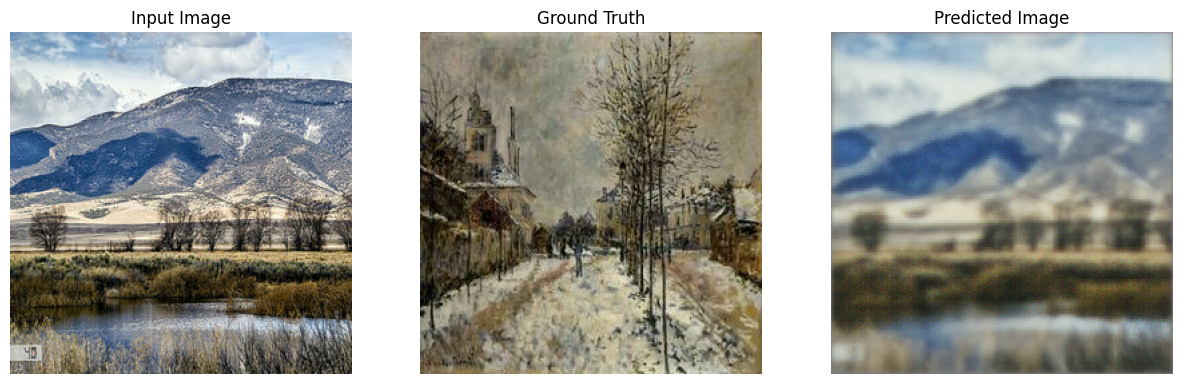

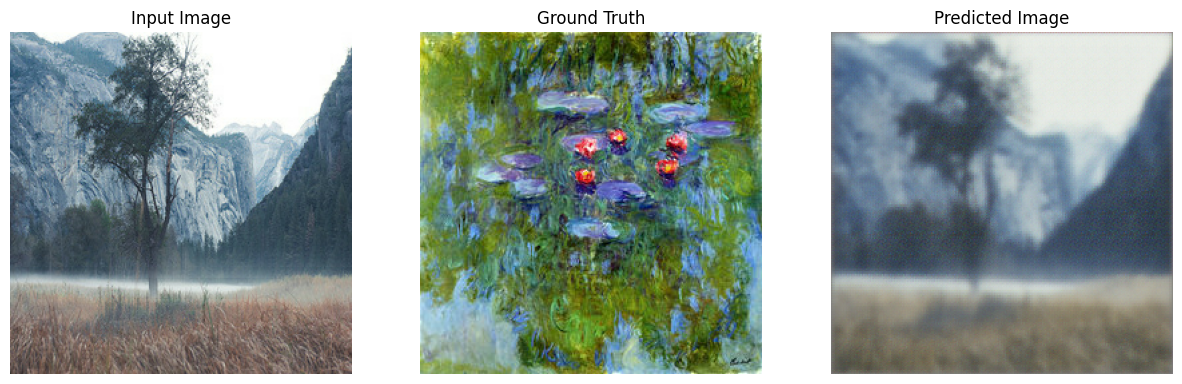

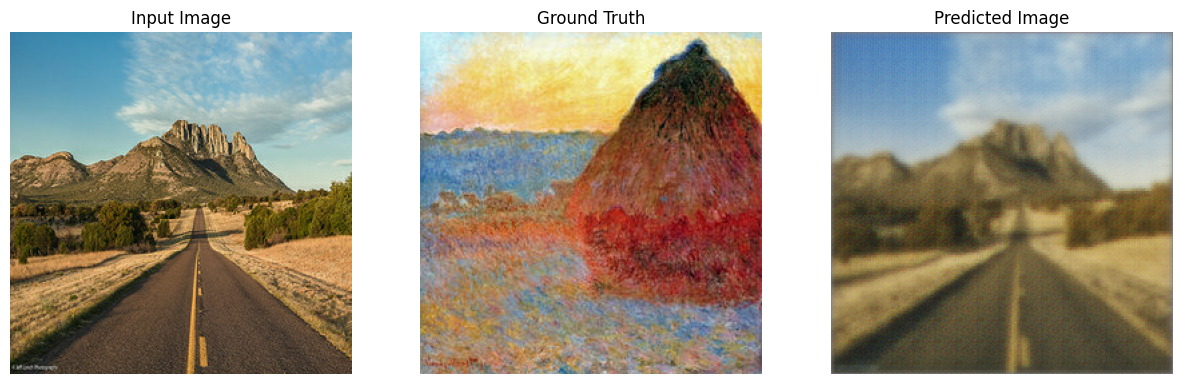

Model 2:


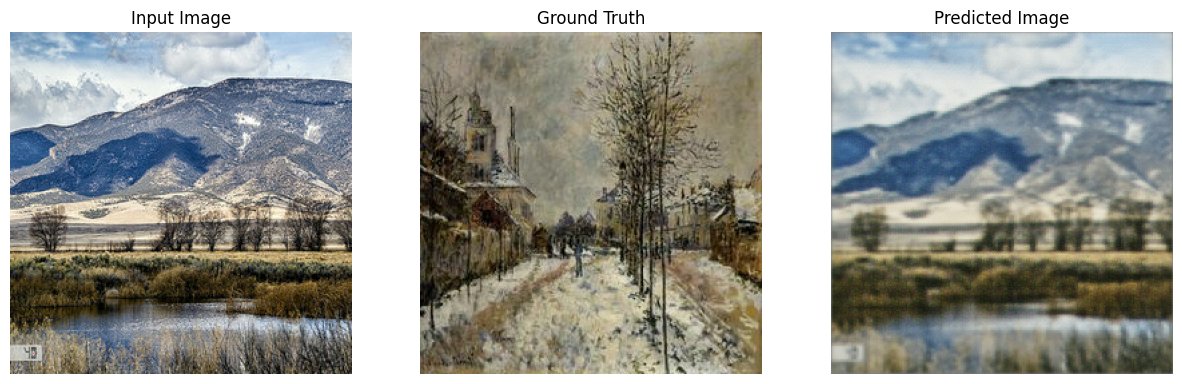

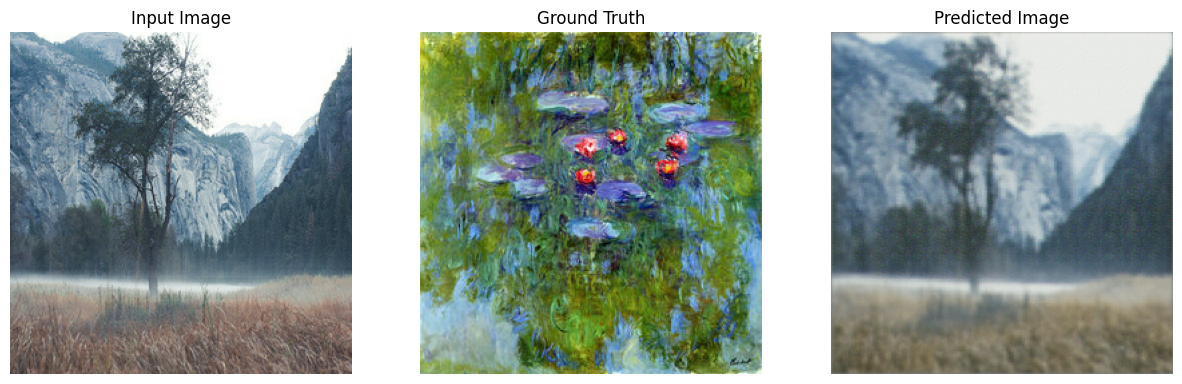

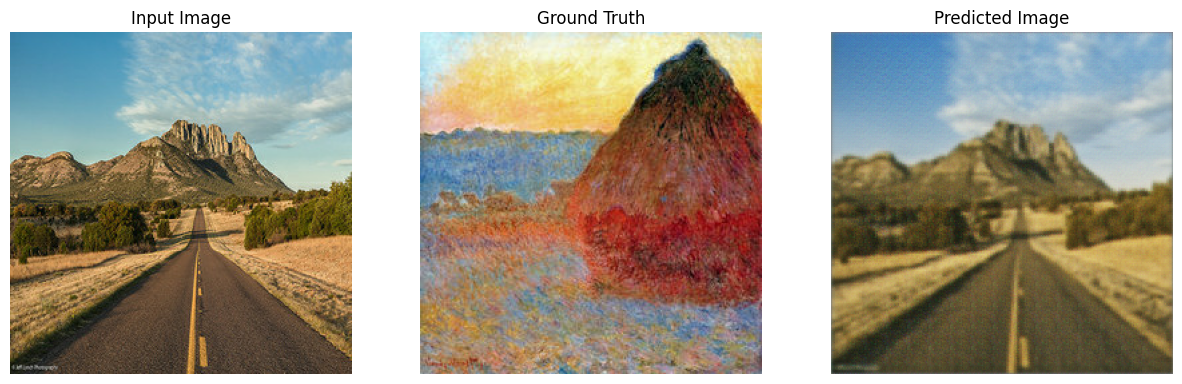

In [11]:
import matplotlib.pyplot as plt

batch_size = 16
dataset = tf.data.Dataset.zip((
    photo_dataset,
    monet_dataset.take(batch_size * 18)
)).batch(batch_size)

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()

print('Model 1:')
for photo, monet in dataset.take(3):
    generate_images(model1, photo, monet)

if IS_DEV:
    print('Model 2:')
    for photo, monet in dataset.take(3):
        generate_images(model2, photo, monet)

Like the plots above shows, due to small epoch number of my development environment, the image generated has the style of monet, but it's not great. In the submission of kaggle competition I used bigger epoch number and got a much better result. Higher learning rate will faster model's convergence process, with the same epoch number, higher learning rate model get better performance in this test (the image generated is more clear).

## Conclusion

**Learnings and Takeaways**

- The U-Net architecture was the most effective in generating high-quality Monet-style images due to its skip connections, which preserved spatial information.

- Hyperparameter tuning, particularly the learning rate and batch size, played a crucial role in stabilizing and improving the training process.

- The CycleGAN architecture provided additional flexibility with bi-directional style transfer but required more resources and time for training.

**Future Improvements**

- Experimenting with different types of loss functions, such as feature matching or perceptual loss, to further enhance image quality.

- Utilizing more advanced GAN architectures like StyleGAN for potentially higher-quality outputs.

- Increasing the dataset size by incorporating more Monet paintings and photos for training.

## Create submission file

Let's create the final submission file for kaggle competition.

In [10]:
import PIL
import shutil

! mkdir ../images

i = 1
for img in photo_dataset:
    prediction = model1(np.expand_dims(img, axis=0), training=True)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    if IS_DEV and i == 3:
        break

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


mkdir: cannot create directory '../images': File exists


'/kaggle/working/images.zip'